In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
A1 = pd.read_csv("data//1//A.csv")
A1.head(10)

,Time,BidPrice1,BidPrice2,BidPrice3,BidPrice4,BidPrice5,BidVolume1,BidVolume2,BidVolume3,BidVolume4,...,OrderBuyVolume,OrderSellVolume,TradeBuyNum,TradeSellNum,TradeBuyVolume,TradeSellVolume,TradeBuyAmount,TradeSellAmount,LastPrice,Return5min
0,93000000,16888,16863,16838,16828,16826,200,100,200,400,...,731200,1634634,483,638,117120,239980,1979328000,4055662000,16900,-0.009501
1,93000500,16790,16788,16784,16780,16777,2000,600,400,100,...,179700,353040,436,67,153140,15460,2582667080,259925600,16880,-0.003585
2,93001000,16900,16800,16790,16788,16784,21129,27500,2000,600,...,224300,148200,496,27,157471,4900,2658481120,82460000,16900,-0.010040
3,93001500,16900,16889,16888,16870,16829,429,400,100,100,...,84000,140200,56,235,9300,74300,157308700,1255732300,16900,-0.011330
4,93002000,16800,16790,16788,16784,16780,28500,2000,600,400,...,35800,135900,101,39,21600,9429,364444000,158850600,16800,-0.006846
5,93002500,16863,16845,16815,16800,16799,500,700,300,25700,...,30600,90580,92,17,19600,6200,330777000,104277300,16888,-0.008908
6,93003000,16800,16799,16790,16788,16784,23000,100,2000,600,...,41400,92500,111,17,31800,4700,536366500,79030200,16825,-0.004931
7,93003500,16826,16800,16799,16790,16788,200,22800,100,2000,...,79000,75800,174,37,63100,9300,1065802545,156995800,16870,-0.006452
8,93004000,16916,16904,16901,16900,16888,2529,100,600,1700,...,45400,39200,80,34,25571,8800,431764255,148685000,16916,-0.010603
9,93004500,16850,16803,16801,16800,16799,1900,100,200,22900,...,27600,65800,67,95,12200,16129,205571824,272338064,16888,-0.007379


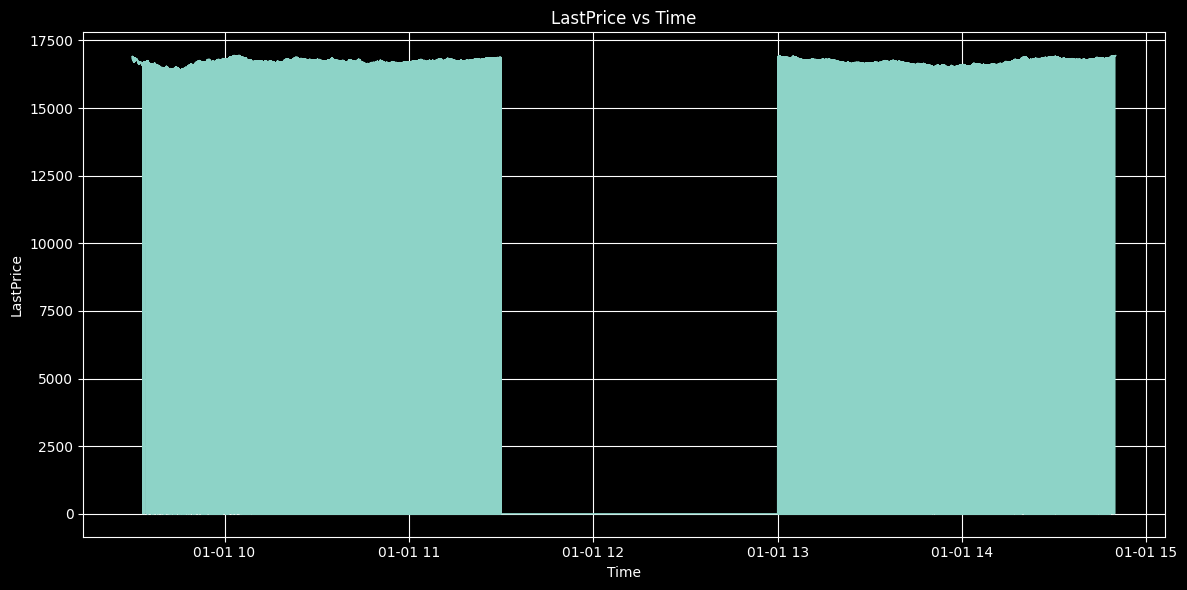

In [6]:
def convert_tick_time(tick_time, date_value=None):
    # 处理缺失
    if pd.isna(tick_time):
        return pd.NaT
    s = str(int(tick_time))
    def valid(h, m, sec):
        return 0 <= h < 24 and 0 <= m < 60 and 0 <= sec < 60

    # 尝试多种切分（优先常见的 8 位 HHMMSSff，然后尝试 7 位、最后按右侧固定宽度解析）
    tries = []
    tries.append(lambda x: (int(x[0:2]), int(x[2:4]), int(x[4:6]), int(x[6:8])))           # zfill(8)
    tries.append(lambda x: (int(x[0:1]), int(x[1:3]), int(x[3:5]), int(x[5:7])))           # zfill(7)
    def right_fixed(x):
        frac = int(x[-2:]) if len(x) >= 2 else 0
        sec = int(x[-4:-2]) if len(x) >= 4 else 0
        minute = int(x[-6:-4]) if len(x) >= 6 else 0
        hour = int(x[:-6]) if len(x) > 6 else 0
        return (hour, minute, sec, frac)
    tries.append(lambda x: right_fixed(x))

    for fn in tries:
        try:
            # 使用不同填充长度以便切片安全
            candidate = fn(s.zfill(8) if fn is tries[0] else (s.zfill(7) if fn is tries[1] else s))
            h, m, sec, frac = candidate
        except Exception:
            continue
        if valid(h, m, sec):
            microsecond = int(frac) * 10000  # 两位百分秒 -> 微秒
            # 使用提供的日期（若存在），否则用示例日期
            if date_value is not None and not pd.isna(date_value):
                try:
                    base_date = pd.to_datetime(date_value).normalize()
                except Exception:
                    base_date = pd.Timestamp(year=2026, month=1, day=1)
            else:
                base_date = pd.Timestamp(year=2026, month=1, day=1)
            return pd.Timestamp(year=base_date.year, month=base_date.month, day=base_date.day,
                                hour=h, minute=m, second=sec, microsecond=microsecond)
    # 全部解析失败
    return pd.NaT

# 使用说明（在你的 DataFrame `A1` 上应用）
# 如果有 `Date` 列：按照行应用以使用各行日期；否则直接按列应用
if 'Date' in A1.columns:
    A1['Time'] = A1.apply(lambda r: convert_tick_time(r['Time'], r['Date']), axis=1)
else:
    A1['Time'] = A1['Time'].apply(convert_tick_time)

A1 = A1.set_index('Time').sort_index()

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(A1.index, A1['LastPrice'], lw=1)
plt.xlabel('Time')
plt.ylabel('LastPrice')
plt.title('LastPrice vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()